In [11]:
import pandas as pd
from training_claude import load_agent, evaluate_agent
from rl_env import FlexSimEnv
from eval import evaluate_heuristic
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import create_field_from_list_column
from params import ON_TIME_BOUNDS, N_STOPS, MAX_TIME_HOURS
# resolution to 100 dpi
mpl.rcParams['figure.dpi'] = 120

In [12]:
def get_deviation_totals(state):
   non_zero_requests = state[state['n_requests'] > 0].copy()
   
   episode_results = non_zero_requests.groupby(['scenario', 'episode']).agg({
       'n_requests': 'size',
       'action': 'sum'
   }).rename(columns={'n_requests': 'deviation_chances', 'action': 'deviations'})
   
   return episode_results.groupby('scenario')[['deviation_chances', 'deviations']].mean().round(1).reset_index()

def get_flex_pax_totals(pax):
    # rejection rate per episode
    episode_results = pax.groupby(['scenario', 'episode'])[['rejected', 'flex']].sum().reset_index()
    return episode_results.groupby(['scenario'])[['rejected', 'flex']].mean().round(1).reset_index()

def get_trips_totals(trips):
   terminal_trips = trips[trips['stop']==N_STOPS-1].copy()
   episode_results = terminal_trips.groupby(['scenario', 'episode']).agg({
       'arrival_time': 'size',
       'off_schedule': 'sum'
   }).rename(columns={'arrival_time': 'n_trips'})
   return episode_results.groupby(['scenario'])[['n_trips', 'off_schedule']].mean().round(1).reset_index()

def get_statistical_significance_test(df, scenario1, scenario2, metric):
    """
    Perform a statistical significance test (t-test) between two scenarios for a given metric.
    """
    # Filter the DataFrame for the two scenarios
    scenario1_data = df[df['scenario'] == scenario1][metric]
    scenario2_data = df[df['scenario'] == scenario2][metric]

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(scenario1_data, scenario2_data)

    return round(t_stat,3), round(p_value,3)

def get_acceptance_rate_distributions(pax):
    episode_results = pax.groupby(['scenario', 'episode'])[['rejected', 'flex']].sum().reset_index()
    episode_results['acceptance_rate'] = episode_results['flex'] / (episode_results['flex'] + episode_results['rejected'])
    episode_results.drop(columns=['rejected', 'flex'], inplace=True)
    return episode_results

def get_on_schedule_rate_distributions(trips):
   terminal_trips = trips[trips['stop']==N_STOPS-1].copy()
   episode_results = terminal_trips.groupby(['scenario', 'episode']).agg({
       'arrival_time': 'size',
       'off_schedule': 'sum'
   }).rename(columns={'arrival_time': 'n_trips'}).reset_index()
   episode_results['on_schedule_rate'] = (episode_results['n_trips'] - episode_results['off_schedule']) / episode_results['n_trips']
   episode_results.drop(columns=['n_trips', 'off_schedule'], inplace=True)
   return episode_results

## testing

In [14]:
main_history = {
    'pax': [],
    'state': [],
    'vehicles': [],
    'idle': [],
}
N_EPISODES = 30
RANDOM_SEED = 1

# slope scenarios
slopes = [1.2, 1.5, 1.8]
slope_scenario_names = ['slope_1_2', 'slope_1_5', 'slope_1_8']

for i in range(len(slopes)):
    np.random.seed(RANDOM_SEED)
    tmp_history = evaluate_heuristic(
        slope=slopes[i], n_episodes=N_EPISODES, 
        output_history=True,
        scenario_name=slope_scenario_names[i])
    for ky in tmp_history:
        if ky not in main_history:
            main_history[ky] = []
        main_history[ky].append(tmp_history[ky])

# RL scenarios

model_paths = ['models/dqn_weight_4_5.pth', 
               'models/dqn_weight_5_0.pth',
               'models/dqn_weight_5_5.pth']
scenario_names = [
    'dqn_4_5',
    'dqn_5_0',
    'dqn_5_5'
]
env = FlexSimEnv()
for i in range(len(model_paths)):
    tmp_agent = load_agent(model_paths[i])
    np.random.seed(RANDOM_SEED)
    tmp_history, tmp_summary = evaluate_agent(
    env, tmp_agent, num_episodes=N_EPISODES, output_history=True,
    scenario_name=scenario_names[i])
    print(tmp_summary)
    for ky in tmp_history:
        if ky not in main_history:
            main_history[ky] = []
        main_history[ky].append(tmp_history[ky])

history_merged = {}
# now concatenate within each main key
for ky in main_history.keys():
    history_merged[ky] = pd.concat(main_history[ky], axis=0)

{'mean_reward': -2.27, 'std_reward': 1.984, 'deviation_opportunities': 43.0, 'deviations': 42.7, 'avg_picked_requests': 1.7, 'early_trips': 8.4, 'late_trips': 34.9}
{'mean_reward': -2.599, 'std_reward': 2.115, 'deviation_opportunities': 41.1, 'deviations': 36.1, 'avg_picked_requests': 1.7, 'early_trips': 8.8, 'late_trips': 38.0}
{'mean_reward': -2.18, 'std_reward': 1.992, 'deviation_opportunities': 42.4, 'deviations': 42.4, 'avg_picked_requests': 1.7, 'early_trips': 8.9, 'late_trips': 34.5}


## Write

In [ ]:
# for ky in history_merged:
#     history_merged[ky].to_csv(f'outputs/experiments/{ky}.csv', index=False)

## Read from file

In [257]:
# history_merged = {'pax': [], 'state': [], 'vehicles': [], 'idle': []}
# for ky in history_merged:
#     history_merged[ky] = pd.read_csv(f'outputs/experiments/{ky}.csv')

## Evaluation

In [15]:
# import stats library for ttest
from scipy import stats

In [16]:
ANALYSIS_START_TIME = (0.5)*3600
ANALYSIS_END_TIME = (MAX_TIME_HOURS-1.5)*3600

# pre processing
# pax
pax = history_merged['pax'].copy()
pax = pax[pax['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
pax['arrival_hour'] = (pax['arrival_time']/3600).astype(int)
pax = pax[pax['arrival_hour']<3]
pax['rejected'] = (pax['boarding_time'].isna().astype(int)) & (pax['flex'] == 1) # rejected from their perspective
pax['ride_time'] = pax['arrival_time'] - pax['boarding_time']

# trips
trips = history_merged['vehicles'].copy()
trips = trips[trips['arrival_time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
trips['hour'] = (trips['arrival_time']/3600).astype(int)
trips = trips[trips['hour']<3]
trips['off_schedule'] = (~trips['delay'].between(
    ON_TIME_BOUNDS[0], ON_TIME_BOUNDS[1], inclusive='both')).astype(int)

# state
state = history_merged['state'].copy()
state = state[state['time'].between(ANALYSIS_START_TIME, ANALYSIS_END_TIME)]
state['hour'] = (state['time']/3600).astype(int)
state['observation'] = state['observation'].astype(str)
create_field_from_list_column(state, list_index=1, new_field_name='n_requests', field_name='observation')

# combine all metrics
trips_totals = get_trips_totals(trips)
deviation_totals = get_deviation_totals(state)
flex_pax_totals = get_flex_pax_totals(pax)
combined_totals = pd.merge(trips_totals, deviation_totals, on='scenario')
combined_totals = pd.merge(combined_totals, flex_pax_totals, on='scenario')
combined_totals['method'] = combined_totals['scenario'].apply(lambda x: 'RL' if 'dqn' in x else 'heuristic')

combined_totals['on_schedule_rate'] = (100 - combined_totals['off_schedule'] / combined_totals['n_trips'] * 100).round(2)
combined_totals['acceptance_rate'] = (100 - combined_totals['rejected'] / combined_totals['flex'] * 100).round(2)

In [265]:
# keep_scenarios = ['dqn_3_0', 'dqn_3_2', 'slope_1_5', 'slope_1_2']
# combined_totals = combined_totals[combined_totals['scenario'].isin(keep_scenarios)]

In [266]:
# pax[pax['scenario'].isin(keep_scenarios)].groupby(['scenario'])['wait_time'].quantile(0.95)

In [17]:
combined_totals

,scenario,n_trips,off_schedule,deviation_chances,deviations,rejected,flex,method,on_schedule_rate,acceptance_rate
0,dqn_4_5,26.1,16.0,34.7,34.4,6.6,60.4,RL,38.70,89.07
1,dqn_5_0,25.3,16.1,33.0,29.8,11.0,58.6,RL,36.36,81.23
2,dqn_5_5,26.9,16.0,34.6,34.6,5.2,57.7,RL,40.52,90.99
3,slope_1_2,29.9,8.5,46.0,29.6,9.1,61.0,heuristic,71.57,85.08
4,slope_1_5,29.9,8.3,46.3,26.8,10.8,57.5,heuristic,72.24,81.22
5,slope_1_8,29.9,9.4,48.1,23.2,15.1,58.1,heuristic,68.56,74.01


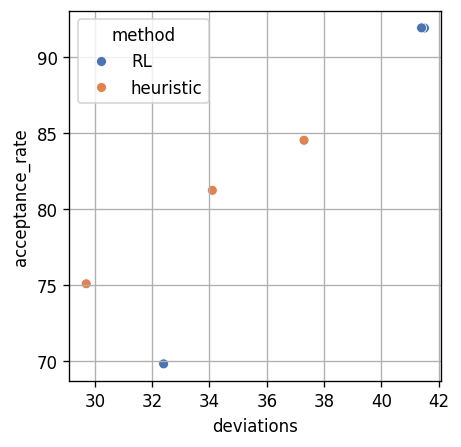

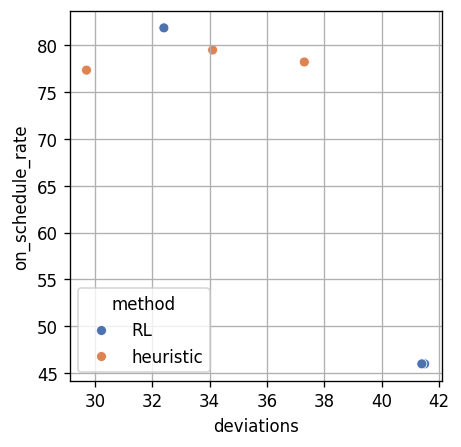

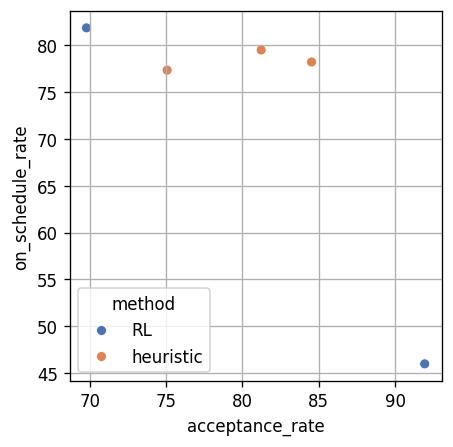

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(
    data=combined_totals,
    x='deviations',
    y='acceptance_rate',
    hue='method',
    palette='deep',
    ax=ax,
)
ax.grid(True)

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(
    data=combined_totals,
    x='deviations',
    y='on_schedule_rate',
    hue='method',
    palette='deep'
)
# ax.legend().remove()
ax.grid(True)

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(
    data=combined_totals,
    x='acceptance_rate',
    y='on_schedule_rate',
    hue='method',
    palette='deep'
)
# ax.legend().remove()
ax.grid(True)

In [ ]:
osr_dist = get_on_schedule_rate_distributions(trips[trips['scenario'].isin(keep_scenarios)])
ar_dist = get_acceptance_rate_distributions(pax[pax['scenario'].isin(keep_scenarios)])

In [251]:
get_statistical_significance_test(
    osr_dist, 'dqn_3_2', 'slope_1_5', 'on_schedule_rate'
)

(1.586, 0.118)

In [252]:
get_statistical_significance_test(
    ar_dist, 'dqn_3_2', 'slope_1_5', 'acceptance_rate'
)

(1.11, 0.272)

In [254]:
get_statistical_significance_test(
    pax.dropna(), 'dqn_3_2', 'slope_1_5', 'wait_time'
)

(-1.151, 0.25)

## inspect RL reward

In [18]:
from params import CONTROL_STOPS, FLEX_STOPS, N_STOPS

In [25]:
s = state[state['scenario'].astype(str).str[:4] == 'dqn_'].copy()
s = s[s['scenario']=='dqn_5_0'].copy()
s = s[s['episode']==1].copy()
s = s[s['veh_idx']==0].copy()
s['unweighted_rewards'] = s['unweighted_rewards'].astype(str)
create_field_from_list_column(s, list_index=1, new_field_name='delay_reward', field_name='unweighted_rewards')
create_field_from_list_column(s, list_index=3, new_field_name='delay', field_name='observation')
create_field_from_list_column(s, list_index=0, new_field_name='stop', field_name='observation')

t = trips[trips['scenario'].astype(str).str[:4] == 'dqn_'].copy()
t = t[t['scenario']=='dqn_5_0'].copy()
t = t[t['episode']==1].copy()
t = t[t['veh_idx']==0].copy()
t = t[t['stop'].isin(CONTROL_STOPS + FLEX_STOPS + [N_STOPS-1])].copy()

In [26]:
s.sort_values(by=['veh_idx', 'time'], ).head(30)

,time,observation,action,reward,unweighted_rewards,veh_idx,episode,scenario,hour,n_requests,delay_reward,delay,stop
2,1904.0,"[2, 0, 568.0, -56.0]",0,0.0,"[0, 0]",0,1,dqn_5_0,0,0.0,0.0,-56.0,2.0
3,2029.0,"[3, 0, 506.0, -85.0]",0,0.0,"[0, 0]",0,1,dqn_5_0,0,0.0,0.0,-85.0,3.0
4,2596.0,"[0, 0, 599.0, 36.0]",0,0.0,"[0, 0]",0,1,dqn_5_0,0,0.0,0.0,36.0,0.0
5,2692.0,"[1, 0, 488.0, -16.0]",0,-4.0,"[0, 1]",0,1,dqn_5_0,0,0.0,1.0,-16.0,1.0
6,3132.0,"[2, 1, 504.0, -32.0]",1,0.0,"[0, 0]",0,1,dqn_5_0,0,1.0,0.0,-32.0,2.0
7,3314.0,"[3, 0, 528.0, 4.0]",0,0.0,"[0, 0]",0,1,dqn_5_0,0,0.0,0.0,4.0,3.0
8,3735.0,"[0, 2, 450.0, -23.0]",1,0.0,"[0, 0]",0,1,dqn_5_0,1,2.0,0.0,-23.0,0.0
9,3968.0,"[1, 0, 474.0, 60.0]",0,0.0,"[0, 0]",0,1,dqn_5_0,1,0.0,0.0,60.0,1.0
10,4313.0,"[2, 0, 239.0, -49.0]",0,-4.0,"[0, 1]",0,1,dqn_5_0,1,0.0,1.0,-49.0,2.0


In [28]:
t

,direction,trip_id,stop,arrival_time,departure_time,load,boardings,alightings,scheduled_time,veh_idx,headway,flex,episode,scenario,delay,hour,off_schedule
17,in,2,1,1894.0,1904.0,2,2,0,1950,0,568.0,0,1,dqn_5_0,-56.0,0,0
18,in,2,3,2015.0,2029.0,2,2,2,2100,0,506.0,0,1,dqn_5_0,-85.0,0,0
20,in,2,6,2332.0,2342.0,0,0,2,2400,0,505.0,0,1,dqn_5_0,-68.0,0,0
22,out,4,1,2586.0,2596.0,3,2,0,2550,0,599.0,0,1,dqn_5_0,36.0,0,0
23,out,4,3,2684.0,2692.0,2,0,1,2700,0,488.0,0,1,dqn_5_0,-16.0,0,0
25,out,4,6,2880.0,2888.0,0,0,1,3000,0,428.0,0,1,dqn_5_0,-120.0,0,1
27,in,4,1,3118.0,3132.0,3,3,1,3150,0,504.0,0,1,dqn_5_0,-32.0,0,0
28,in,4,2,3207.0,3215.0,4,1,0,3225,0,506.0,1,1,dqn_5_0,-18.0,0,0
29,in,4,3,3304.0,3314.0,4,1,1,3300,0,528.0,0,1,dqn_5_0,4.0,0,0
31,in,4,6,3567.0,3585.0,0,0,6,3600,0,455.0,0,1,dqn_5_0,-33.0,0,0
